## Regression Using NLP Text

I decided to not keep this on my HuggingFace Profile.

Data Source: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv

#### Import Necessary Libraries

In [1]:
import os, math, random, re # , logging
os.environ['TOKENIZERS_PARALLELISM']='false'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Ingest Data, Drop Unnecessary Columns, & Rename Remaining Columns

In [2]:
data = pd.read_csv('~/Documents/nlpnn/Datasets/TMDB 500 Movie Dataset/tmdb_5000_movies.csv', engine="c")

data = data[data['original_language'] == 'en']

data['text'] = data['title'] + ' : ' + data['tagline'] + ' : ' + data['overview'] 

data.drop(columns=['budget', 'genres', 'homepage', 'id', 'status', 
                   'spoken_languages', 'production_countries', 
                   'production_companies', 'release_date', 
                   'revenue', 'runtime', 'original_title', 
                   'keywords', 'original_language', 
                   'overview', 'title', 'tagline', 
                   'vote_count', 'popularity'], inplace=True)

data.reset_index(inplace=True, drop=True)

data.rename(columns={'vote_average' : 'label'}, inplace=True)

data.dropna(inplace=True)

data

,label,text
0,7.2,Avatar : Enter the World of Pandora. : In the ...
1,6.9,Pirates of the Caribbean: At World's End : At ...
2,6.3,Spectre : A Plan No One Escapes : A cryptic me...
3,7.6,The Dark Knight Rises : The Legend Ends : Foll...
4,6.1,"John Carter : Lost in our world, found in anot..."
...,...,...
4496,6.0,On The Downlow : Two gangs. One secret. One cr...
4498,6.0,Bang : Sometimes you've got to break the rules...
4499,6.9,Primer : What happens if it actually works? : ...
4501,5.9,Newlyweds : A newlywed couple's honeymoon is u...


Visualize Distribution of Scores

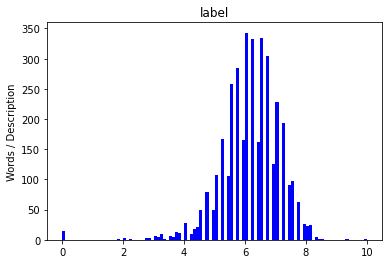

In [3]:
data.hist("label", color="Blue", grid=False, bins=100)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Words / Description')
plt.show()

Visualize Distribution of Message Length

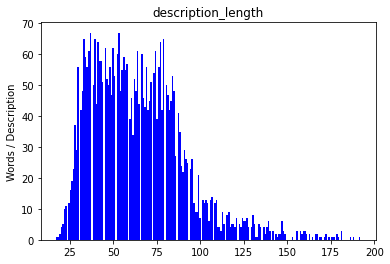

In [4]:
data['description_length'] = data['text'].str.split().apply(len)

data.hist("description_length", color="Blue", grid=False, bins=200)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Words / Description')
plt.show()

#### Final Preprocessing

In [5]:
data = data[data['label'] > 0.2]
data = data.drop(columns=['description_length'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3774 entries, 0 to 4503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   3774 non-null   float64
 1   text    3774 non-null   object 
dtypes: float64(1), object(1)
memory usage: 88.5+ KB


#### Convert Pandas DataFrame to Datasets

In [6]:
dataset = Dataset.from_pandas(data)

#### Split into Train/Test/Validate Datasets & Combine into DatasetDict

In [7]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (3019, 3)
Testing data shape: (378, 3)
Eval data shape: (377, 3)


#### Basic Values

In [8]:
num_of_epochs = 15
max_input_len = 245
model_ckpt = "distilbert-base-uncased"
device = "cpu"
num_labels = 1
BATCH_SIZE=64
model_name = f"{model_ckpt}-Regression-TMDB_5000_Movie_Dataset"
learning_rate=2e-5
set_seed(42)

#### HuggingFace Access Token & Install git lfs 

In [9]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Whole Dataset

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 3019
})


#### Initialize Model

In [12]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

#### Metrics Evaluation Function

In [13]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    accuracy = sum(
        [1 for e in single_squared_errors if e < 0.05]) / len(single_squared_errors)
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "accuracy": accuracy, "r2": r2}

#### Trainer Arguments

In [14]:
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=num_of_epochs, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=learning_rate,
                                  evaluation_strategy='epoch',
                                  save_total_limit=12,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='rmse',
                                  greater_is_better=False,
                                  save_strategy='epoch', 
                                  optim='adamw_hf',
                                  push_to_hub=True)

#### Instantiate Optimizer

In [15]:
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(encoded_ds['train'])

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer_name, num_warmup_steps=0, num_training_steps=num_training_steps
)

optimizer = [optimizer_name, lr_scheduler]

#### Build Trainer

In [16]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  optimizers=optimizer, 
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

/Users/briandunn/Documents/nlpnn/nlp_projects/distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset is already a clone of https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train the Trainer

In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3019
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 720


  0%|          | 0/720 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48/special_tokens_map.json


{'eval_loss': 2.200951099395752, 'eval_mse': 2.200951099395752, 'eval_rmse': 1.48356032371521, 'eval_mae': 1.297607421875, 'eval_accuracy': 0.050397877984084884, 'eval_r2': -1.5416074272685232, 'eval_runtime': 193.6346, 'eval_samples_per_second': 1.947, 'eval_steps_per_second': 0.031, 'epoch': 1.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96/config.json


{'eval_loss': 0.8820900321006775, 'eval_mse': 0.8820900321006775, 'eval_rmse': 0.9391964673995972, 'eval_mae': 0.7192559242248535, 'eval_accuracy': 0.20689655172413793, 'eval_r2': -0.018617198265002965, 'eval_runtime': 194.6414, 'eval_samples_per_second': 1.937, 'eval_steps_per_second': 0.031, 'epoch': 2.0}


Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144/special_tokens_map.json


{'eval_loss': 0.8279125690460205, 'eval_mse': 0.8279125690460205, 'eval_rmse': 0.9098970293998718, 'eval_mae': 0.6988300085067749, 'eval_accuracy': 0.20159151193633953, 'eval_r2': 0.04394564949174762, 'eval_runtime': 195.7433, 'eval_samples_per_second': 1.926, 'eval_steps_per_second': 0.031, 'epoch': 3.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192/special_tokens_map.json


{'eval_loss': 0.8107514977455139, 'eval_mse': 0.8107514977455139, 'eval_rmse': 0.9004173874855042, 'eval_mae': 0.6997339129447937, 'eval_accuracy': 0.18037135278514588, 'eval_r2': 0.06376292787065119, 'eval_runtime': 194.7712, 'eval_samples_per_second': 1.936, 'eval_steps_per_second': 0.031, 'epoch': 4.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-240
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-240/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-240/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-240/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-240/special_tokens_map.json


{'eval_loss': 0.8415805697441101, 'eval_mse': 0.8415805101394653, 'eval_rmse': 0.9173769950866699, 'eval_mae': 0.7173587679862976, 'eval_accuracy': 0.1962864721485411, 'eval_r2': 0.028162233811685478, 'eval_runtime': 195.5079, 'eval_samples_per_second': 1.928, 'eval_steps_per_second': 0.031, 'epoch': 5.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-288
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-288/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-288/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-288/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-288/special_tokens_map.json


{'eval_loss': 0.8787928223609924, 'eval_mse': 0.878792941570282, 'eval_rmse': 0.9374395608901978, 'eval_mae': 0.7272850275039673, 'eval_accuracy': 0.20159151193633953, 'eval_r2': -0.01480975230728454, 'eval_runtime': 193.2303, 'eval_samples_per_second': 1.951, 'eval_steps_per_second': 0.031, 'epoch': 6.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-336
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-336/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-336/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-336/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-336/special_tokens_map.json


{'eval_loss': 0.9337195158004761, 'eval_mse': 0.9337194561958313, 'eval_rmse': 0.966291606426239, 'eval_mae': 0.7476375699043274, 'eval_accuracy': 0.21220159151193635, 'eval_r2': -0.07823770916338169, 'eval_runtime': 195.2017, 'eval_samples_per_second': 1.931, 'eval_steps_per_second': 0.031, 'epoch': 7.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-384
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-384/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-384/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-384/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-384/special_tokens_map.json


{'eval_loss': 1.0650649070739746, 'eval_mse': 1.065064787864685, 'eval_rmse': 1.0320197343826294, 'eval_mae': 0.8039134740829468, 'eval_accuracy': 0.1883289124668435, 'eval_r2': -0.22991224415457, 'eval_runtime': 196.5623, 'eval_samples_per_second': 1.918, 'eval_steps_per_second': 0.031, 'epoch': 8.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-432
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-432/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-432/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-432/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-432/special_tokens_map.json


{'eval_loss': 0.9062464237213135, 'eval_mse': 0.906246542930603, 'eval_rmse': 0.9519698023796082, 'eval_mae': 0.7524718642234802, 'eval_accuracy': 0.16976127320954906, 'eval_r2': -0.04651255726947601, 'eval_runtime': 199.2434, 'eval_samples_per_second': 1.892, 'eval_steps_per_second': 0.03, 'epoch': 9.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-480
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-480/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-480/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-480/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-480/special_tokens_map.json


{'eval_loss': 0.9021569490432739, 'eval_mse': 0.9021569490432739, 'eval_rmse': 0.9498194456100464, 'eval_mae': 0.7403446435928345, 'eval_accuracy': 0.20159151193633953, 'eval_r2': -0.041790016988830114, 'eval_runtime': 194.694, 'eval_samples_per_second': 1.936, 'eval_steps_per_second': 0.031, 'epoch': 10.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json


{'loss': 1.979, 'learning_rate': 1.9779176327702332e-05, 'epoch': 10.42}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-528
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-528/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-528/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-528/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-528/special_tokens_map.json


{'eval_loss': 0.9014069437980652, 'eval_mse': 0.9014071226119995, 'eval_rmse': 0.9494246244430542, 'eval_mae': 0.7416626214981079, 'eval_accuracy': 0.1962864721485411, 'eval_r2': -0.040924075857609044, 'eval_runtime': 193.3715, 'eval_samples_per_second': 1.95, 'eval_steps_per_second': 0.031, 'epoch': 11.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-576
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-576/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-576/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-576/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-576/special_tokens_map.json


{'eval_loss': 0.9119113087654114, 'eval_mse': 0.9119111895561218, 'eval_rmse': 0.9549404382705688, 'eval_mae': 0.7478482127189636, 'eval_accuracy': 0.1830238726790451, 'eval_r2': -0.053054043985241606, 'eval_runtime': 193.347, 'eval_samples_per_second': 1.95, 'eval_steps_per_second': 0.031, 'epoch': 12.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-624
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-624/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-624/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-624/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-624/special_tokens_map.json


{'eval_loss': 1.0246567726135254, 'eval_mse': 1.0246566534042358, 'eval_rmse': 1.0122532844543457, 'eval_mae': 0.7922786474227905, 'eval_accuracy': 0.16976127320954906, 'eval_r2': -0.18324984696459534, 'eval_runtime': 193.4612, 'eval_samples_per_second': 1.949, 'eval_steps_per_second': 0.031, 'epoch': 13.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
Deleting older checkpoint [distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-48] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-672
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-672/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-672/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-672/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-672/special_tokens_map.json


{'eval_loss': 1.084119439125061, 'eval_mse': 1.0841195583343506, 'eval_rmse': 1.041210651397705, 'eval_mae': 0.8194248080253601, 'eval_accuracy': 0.15384615384615385, 'eval_r2': -0.25191619110329966, 'eval_runtime': 193.3201, 'eval_samples_per_second': 1.95, 'eval_steps_per_second': 0.031, 'epoch': 14.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
Deleting older checkpoint [distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-96] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 377
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-720
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-720/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-720/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-720/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-720/special_tokens_map.json


{'eval_loss': 0.9409171342849731, 'eval_mse': 0.9409172534942627, 'eval_rmse': 0.970008909702301, 'eval_mae': 0.7608776688575745, 'eval_accuracy': 0.17771883289124668, 'eval_r2': -0.0865494694629092, 'eval_runtime': 193.3448, 'eval_samples_per_second': 1.95, 'eval_steps_per_second': 0.031, 'epoch': 15.0}


tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json
Deleting older checkpoint [distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-144] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/checkpoint-192 (score: 0.9004173874855042).


{'train_runtime': 75013.1394, 'train_samples_per_second': 0.604, 'train_steps_per_second': 0.01, 'train_loss': 1.4210472795698377, 'epoch': 15.0}


TrainOutput(global_step=720, training_loss=1.4210472795698377, metrics={'train_runtime': 75013.1394, 'train_samples_per_second': 0.604, 'train_steps_per_second': 0.01, 'train_loss': 1.4210472795698377, 'epoch': 15.0})

#### Predictions

In [18]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 378
  Batch size = 64


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.7613282203674316,
 'eval_mse': 0.7613282203674316,
 'eval_rmse': 0.8725412487983704,
 'eval_mae': 0.6848463416099548,
 'eval_accuracy': 0.17989417989417988,
 'eval_r2': 0.059211118626469994,
 'eval_runtime': 201.8721,
 'eval_samples_per_second': 1.872,
 'eval_steps_per_second': 0.03,
 'epoch': 15.0}

#### Push Model to Hub

In [19]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset
Configuration saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/config.json
Model weights saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/special_tokens_map.json


Upload file runs/Sep21_10-39-12_Brians-Mac-mini.local/events.out.tfevents.1663774756.Brians-Mac-mini.local.167…

Upload file runs/Sep21_10-39-12_Brians-Mac-mini.local/events.out.tfevents.1663850044.Brians-Mac-mini.local.167…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset
   e9d26a5..d166b78  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.17989417989417988}]}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset
   d166b78..61f3ec3  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-TMDB_5000_Movie_Dataset/commit/d166b786b79e28ec3fbcbc739968c304afa37cbe'